**Engy-5310** Computational Continuum Transport Phenomena, UMass Lowell, Chem. Eng. Nuclear Program Spring 2021; Prof. V. F. de Almeida

# Tritium Calculation for Molten Salt Reactor
$  
  \newcommand{\Amtrx}{\boldsymbol{\mathsf{A}}}
  \newcommand{\Bmtrx}{\boldsymbol{\mathsf{B}}}
  \newcommand{\Mmtrx}{\boldsymbol{\mathsf{M}}}
  \newcommand{\Imtrx}{\boldsymbol{\mathsf{I}}}
  \newcommand{\Pmtrx}{\boldsymbol{\mathsf{P}}}
  \newcommand{\Lmtrx}{\boldsymbol{\mathsf{L}}}
  \newcommand{\Umtrx}{\boldsymbol{\mathsf{U}}}
  \newcommand{\Smtrx}{\boldsymbol{\mathsf{S}}}
  \newcommand{\xvec}{\boldsymbol{\mathsf{x}}}
  \newcommand{\uvar}{\boldsymbol{u}}
  \newcommand{\fvar}{\boldsymbol{f}}
  \newcommand{\avec}{\boldsymbol{\mathsf{a}}}
  \newcommand{\bvec}{\boldsymbol{\mathsf{b}}}
  \newcommand{\cvec}{\boldsymbol{\mathsf{c}}}
  \newcommand{\rvec}{\boldsymbol{\mathsf{r}}}
  \newcommand{\mvec}{\boldsymbol{\mathsf{m}}}
  \newcommand{\gvec}{\boldsymbol{\mathsf{g}}}
  \newcommand{\zerovec}{\boldsymbol{\mathsf{0}}}
  \newcommand{\norm}[1]{\bigl\lVert{#1}\bigr\rVert}
  \newcommand{\transpose}[1]{{#1}^\top}
  \DeclareMathOperator{\rank}{rank}
  \newcommand{\Power}{\mathcal{P}}
$

**Student(s):** Anthony Bowers  <br>
**Course:** Engy-5310 Computational Continuum Transport Phenomena  <br>
**Mentor:** Prof. Subash Sharma

UMass Lowell, Dept. of Chemical Engineering, Nuclear Energy Program 
<br>
**25Apr2021**

---
## Table of Contents<a id="toc"></a>
* [Introduction](#intro)
* [Problem Statement](#problem)
* [Objectives](#obj)
* [Approach](#app)
 + [Weak Form of Problem Statement](#weakform)
 + [MOOSE Kernels](#kernels)
 + [Setup](#setup)
* [Results and Analysis](#ranalysis)
* [Conclusions](#conclusions)
* [References](#refs)
---

## [Introduction](#toc)<a id="intro"></a>

Recent technology advances are creating growing interest in nuclear reactors that require advance high temperature salt coolants like Molten Salt Reactor (MSR). In a MSR the fuel is dissolved in the coolant salt with operating temperature at a range of 700oC and 1000oC. At this temperature range the liquid salt produces tritium that can diffuse through metallic heat exchangers and escape the reactor system. To avoid exceeding allowable tritium releases to the environment, tritium removal from the salt coolant and barriers is required. 

In a lithium-containing MSR, the primary tritium-producing reactions as follow

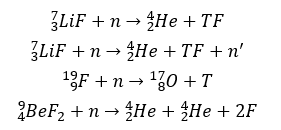

The production rate for the ternary fission reactions, seen above, in an FHR is given by Cisneros (2013). In addition to the production of tritium by ternary fission reactions, tritium is also produced by corrosion, where in an FHR the corrosion reaction (Oxidation of Cr) is given by. 

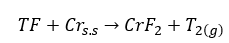


Therefore, the purpose of this project is to understand the tritium transport phenomena and select the correct model which will be tested in MOOSE. MOOSE is a partial differential solver using Finite Element Method (FEM) developed by Idaho National Laboratory. There are already existing models available in literature that have been benchmarks such as TRITium Diffusion EvolutionN and Transport (TRIDENT) developed by Stempien et al (2015,2016) at MIT. 


## [Problem Statement](#toc)<a id="problem"></a>

Consider tritium flowing co-currently, at steady-state, in the main coolant leg with fuel-salt at an initial concentration, u ,and velocity, v. Tritium at the centerline of the bulk fluid is at its max concentration. Alternatively, no tritium is to be diffused into centerline. The latter case was considered in this model. Furthermore, sources indicate that tritium will diffuse into the pipe wall and the diffusion is limited by the mass transfer relation. The mass transfer coefficient was estimated using a Sherwood expression as such: 

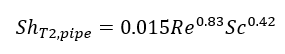

The concentration of tritium in the pipe wall for an infinite slab was assumed to be 0. Lastly, no tritium was to diffuse at the exit flow. 

In [ ]:
pip install pyvista

In [48]:
'''Domain'''

def show_domain():
    import pyvista as pv
    pv.set_plot_theme('paraview')

    height = 150
    radius = 7.5 
    coolant = pv.Cylinder(center=(0,0,0), direction=(1,0,0), height=height, radius=radius)
   

    plo = pv.Plotter(notebook=True,shape=(1,1)) 
    plo.add_mesh(coolant, color='red', opacity=1.0,)
    plo.add_axes(ylabel='Theta', xlabel='Z', zlabel='R')

   
    cpos = plo.show(window_size=[800, 600])

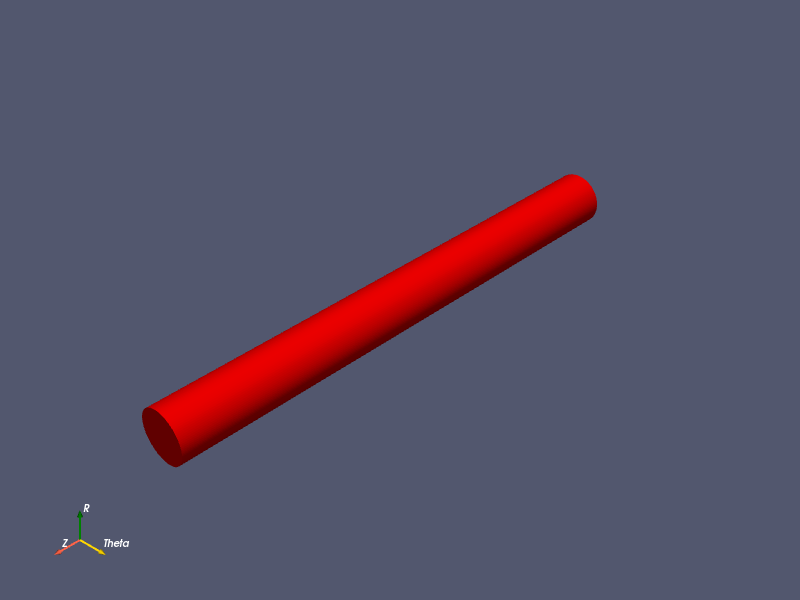

In [49]:
show_domain()

## [Objectives](#toc)<a id="obj"></a>

1.	Obtain transport parameters of tritium in main coolant leg
<br> a.	Peclet number 
<br> b.	Reynolds number
<br> c.	Diffusion coefficients
<br> d.	Fluid properties
2.	Set up analytical solution 
<br> a.	Separation of Variables
<br> b.	Laplace transform
3.	Use MOOSE to determine theoretical solution
4.	Compare analytical to MOOSE


## [Approach](#toc)<a id="app"></a>

    

### [Strong Form of Problem Statement](#toc)<a id="strongform"></a> 

<br>

The transport of tritium follows a 2-D Poisson’s model such that for all  u: [(z1, z2); (r1, r2)] ∈ Real → Real. Currently, this problem neglects the sink and source terms until further coupling mechanics is understood

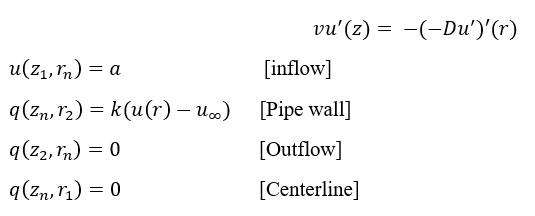

   

### [Weak Form of Problem Statement](#toc)<a id="weakform"></a> 


### [MOOSE Kernels](#toc)<a id="kernels"></a>

The following MOOSE kernels were implemented to solve the [weak form](#weakform):
1. X term: 
 + [interface](./include/kernels/X.h) and [implementation](./src/kernels/X.C).

### [Setup](#toc)<a id="setup"></a>

In [ ]:
'''Domain'''

z_left = 0
z_right =150 
r_bottom=0
r_top=7.5



In [ ]:
'''Parameters'''

diff_coeff = .000266493
s_source = 0



In [ ]:
'''Data (boundary conditions)'''

u_inlet = 3.6e-07
q_center=0
q_bottom=0
ambient_con = 0
vel=5.45
Mass_transfer_coef= 2.35e-03

In [8]:
'''FEM Solution'''

n_felem_x = 1
n_felem_y = 1

order = 'second'

n_plot_pts_x = n_felem_x + 1
n_plot_pts_x = 20
n_plot_pts_y = n_felem_y + 1

from engy_5310_main.toolkit  import write_engy5310_p1_2d_input_file

write_engy5310_p1_2d_input_file(xmin=z_right, 
                                xmax=z_left, 
                                yminx=r_bottom, 
                                ymax=r_top, 
                                u_inlet=u_inlet, 
                                flux_center=q_center,
                                flux_bottom=q_bottom,
                                reference=ambient_con,
                                velocity=vel,
                                transferCoeff=Mass_transfer_coef,
                                diff_coeff=diff_coeff, 
                                source_s=source_s, 
                                n_felem_x=n_felem_x, 
                                n_felem_y=n_felem_y, 
                                order=order, 
                                n_plot_pts_x=n_plot_pts_x, 
                                n_plot_pts_y=n_plot_pts_y)



#n_felem = 10

#order = 'first'

#n_plot_pts = n_felem + 1

#from tools.toolkit import write_engy5310_p1_1d_input_file

#write_engy5310_p1_1d_input_file(x_left=x_a, x_right=x_b, 
                                #u_left=u_a, 
                                #transfer_coeff_right=transfer_coeff_right,
                                #diff_coeff=diff_coeff,
                                #n_felem=n_felem, order=order, 
                                #n_plot_pts=n_plot_pts,
                                #use_moose_neumann_bc=True,
                                #file_name='input.hit')

ModuleNotFoundError: No module named 'engy_5310_main'

In [5]:
!./engy5310p1-opt -i tritium_2d_Horizontal.i

'.' is not recognized as an internal or external command,
operable program or batch file.


## [Results and Analysis](#toc)<a id="ranalysis"></a>

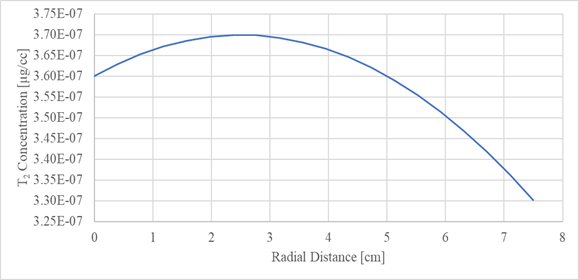

- Text...

## [Conclusions](#toc)<a id="conclusions"></a>

- Text...

- Text...

## [References](#toc)<a id="refs"></a>

- [1] V. F. de Almeida, [*Engy-5310: Computational Continuum Transport Phenomena*](https://github.com/dpploy/engy-5310), University of Massachusetts Lowell, Dept. of Chemical Engineering (Nuclear Energy Program).
- [2] Multiphysics Object-Oriented Simulation Environment [(MOOSE)](https://mooseframework.org)
- [3] author, [reference]()
- [4] author, [reference]()